# Explore

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [15]:
csv_path = r"t2m_hours.csv"   # ajuste o caminho
df = pd.read_csv(csv_path, dtype={"timestamp": str})
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y%m%d%H")
df = df.rename(columns={"t2m": "t2m"})
df = df.set_index("timestamp").sort_index()

In [16]:
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")
df = df.reindex(full_idx)
df["t2m"] = df["t2m"].interpolate(limit_direction="both")


C:\Users\ander\AppData\Local\Temp\ipykernel_24148\4081968388.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")


In [18]:
print("Resumo estatístico:")
print(df["t2m"].describe())
print("Valores faltantes:", df["t2m"].isna().sum())

Resumo estatístico:
count    72.000000
mean     19.290972
std       3.206076
min      15.280000
25%      16.797500
50%      17.585000
75%      22.357500
max      25.780000
Name: t2m, dtype: float64
Valores faltantes: 0


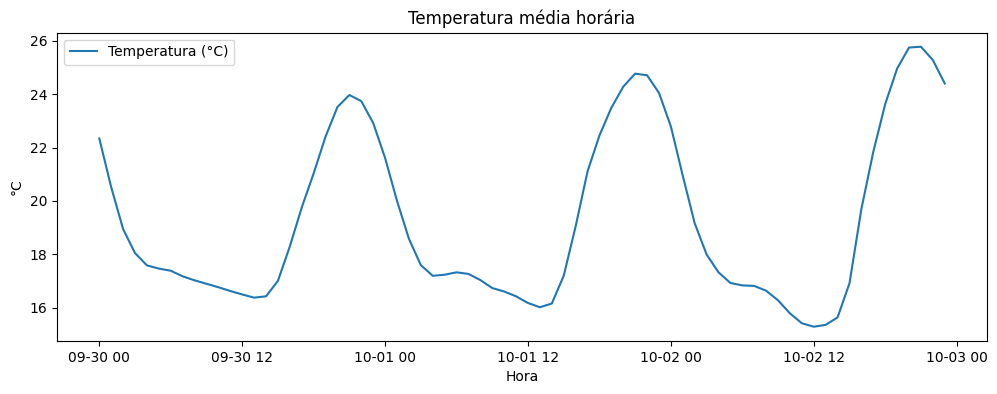

In [19]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df["t2m"], label="Temperatura (°C)")
plt.title("Temperatura média horária")
plt.xlabel("Hora"); plt.ylabel("°C"); plt.legend()
plt.show()

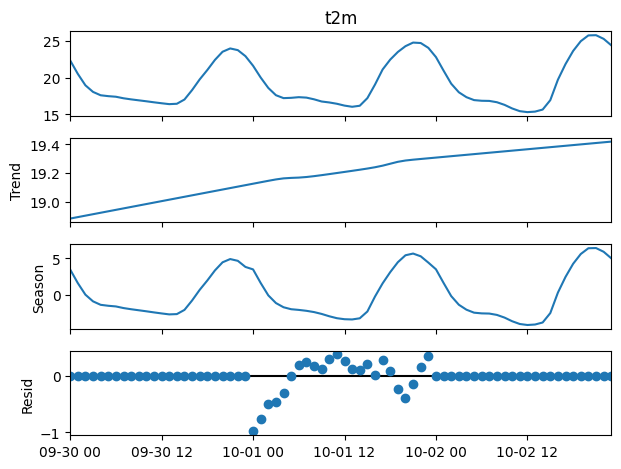

In [20]:
stl = STL(df["t2m"], period=24, robust=True)
res = stl.fit()
res.plot()
plt.show()


In [21]:
def adf_report(series, name="serie"):
    result = adfuller(series.dropna(), autolag="AIC")
    stat, pvalue, usedlag, nobs, crit, icbest = result
    print(f"=== ADF: {name} ===")
    print(f"Estatística: {stat:.3f} | p-valor: {pvalue:.4f}")
    print("Críticos:", crit, "\n")

In [22]:
adf_report(df["t2m"], "t2m original")
adf_report(res.resid, "resíduo STL")

=== ADF: t2m original ===
Estatística: -6.333 | p-valor: 0.0000
Críticos: {'1%': np.float64(-3.5463945337644063), '5%': np.float64(-2.911939409384601), '10%': np.float64(-2.5936515282964665)} 

=== ADF: resíduo STL ===
Estatística: -3.889 | p-valor: 0.0021
Críticos: {'1%': np.float64(-3.5274258688046647), '5%': np.float64(-2.903810816326531), '10%': np.float64(-2.5893204081632653)} 



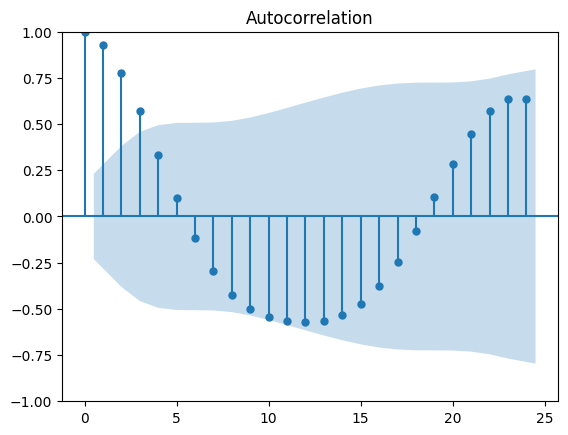

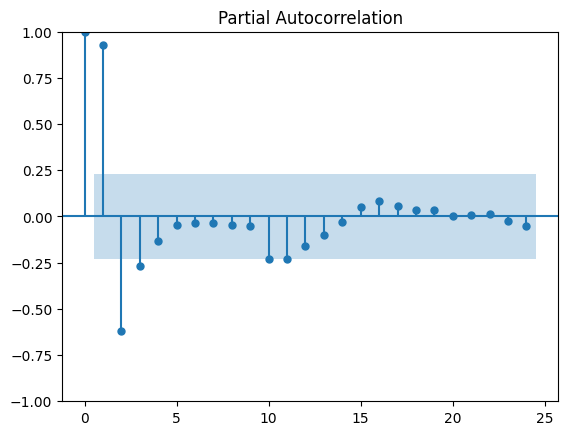

In [23]:
plot_acf(df["t2m"], lags=24); plt.show()
plot_pacf(df["t2m"], lags=24, method="ywm"); plt.show()

# Prediction

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
df = pd.read_csv("t2m_hours.csv", dtype={"timestamp": str})
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y%m%d%H")
df = df.set_index("timestamp").sort_index()

In [26]:
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")
df = df.reindex(full_idx)
df["t2m"] = df["t2m"].interpolate(limit_direction="both")

C:\Users\ander\AppData\Local\Temp\ipykernel_24148\4111747966.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(df.index.min(), df.index.max(), freq="H")


In [27]:
series = df["t2m"]
model = ExponentialSmoothing(
    series,
    trend="add",
    seasonal="add",
    seasonal_periods=24
).fit(optimized=True)


In [ ]:
forecast = model.forecast(24)
print(forecast)

2025-10-03 00:00:00    22.975706
2025-10-03 01:00:00    21.107106
2025-10-03 02:00:00    19.412323
2025-10-03 03:00:00    18.288029
2025-10-03 04:00:00    17.674238
2025-10-03 05:00:00    17.410974
2025-10-03 06:00:00    17.281606
2025-10-03 07:00:00    17.082836
2025-10-03 08:00:00    16.794687
2025-10-03 09:00:00    16.430508
2025-10-03 10:00:00    16.080307
2025-10-03 11:00:00    15.750746
2025-10-03 12:00:00    15.481794
2025-10-03 13:00:00    15.313413
2025-10-03 14:00:00    15.372227
2025-10-03 15:00:00    16.241547
2025-10-03 16:00:00    18.121358
2025-10-03 17:00:00    19.911656
2025-10-03 18:00:00    21.289113
2025-10-03 19:00:00    22.443749
2025-10-03 20:00:00    23.245577
2025-10-03 21:00:00    23.474592
2025-10-03 22:00:00    23.117443
2025-10-03 23:00:00    22.237443
Freq: h, dtype: float64


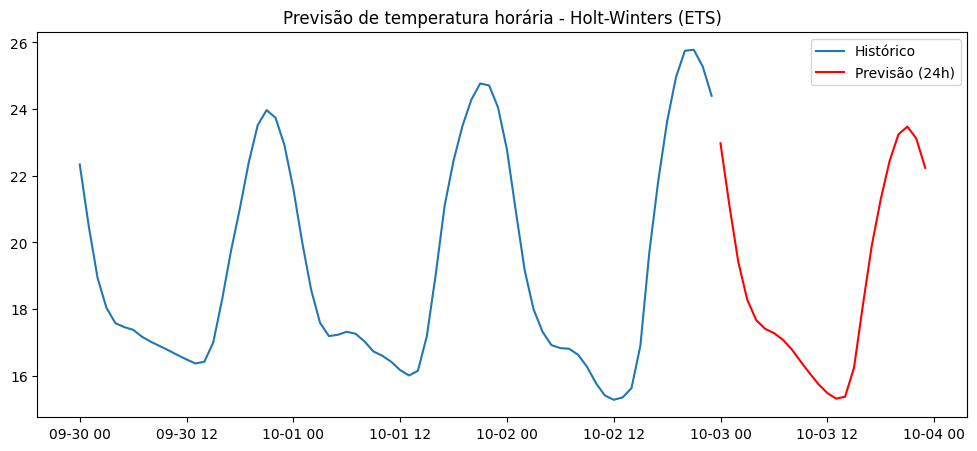

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(series, label="Histórico")
plt.plot(forecast, label="Previsão (24h)", color="red")
plt.legend()
plt.title("Previsão de temperatura horária - Holt-Winters (ETS)")
plt.show()


# Use

In [31]:
# pip install statsmodels pandas numpy

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Union

from statsmodels.tsa.holtwinters import ExponentialSmoothing

def _prep_hourly(x: Union[str, Path, pd.DataFrame]) -> pd.Series:
    if isinstance(x, (str, Path)):
        df = pd.read_csv(str(x), dtype={"timestamp": str})
    elif isinstance(x, pd.DataFrame):
        df = x.copy()
    else:
        raise ValueError("Entrada deve ser caminho ou DataFrame.")

    if "timestamp" not in df or "t2m" not in df:
        raise ValueError("Esperado colunas: 'timestamp' e 't2m'.")

    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y%m%d%H")
    df = df.set_index("timestamp").sort_index()

    # índice horário contínuo + interpolação suave (caso existam buracos)
    idx = pd.date_range(df.index.min(), df.index.max(), freq="H")
    df = df.reindex(idx)
    df["t2m"] = df["t2m"].interpolate(limit_direction="both")
    return df["t2m"]

def forecast24_ets(
    data: Union[str, Path, pd.DataFrame],
    return_as_csv: bool = True,
    decimals: int = 2,
) -> Union[str, np.ndarray]:
    y = _prep_hourly(data)

    # modelo ETS aditivo (trend e sazonalidade aditivas funcionam bem p/ temperatura)
    # Se observar tendência muito fraca, você pode definir trend=None
    model = ExponentialSmoothing(
        y, trend="add", seasonal="add", seasonal_periods=24
    ).fit(optimized=True)

    fc = model.forecast(24).astype(float).values  # np.ndarray com 24 valores

    if return_as_csv:
        vals = [str(round(v, decimals)) for v in fc]
        return ",".join(vals)
    return fc

# ---------------------------
# EXEMPLOS DE USO
# ---------------------------
# 1) Lendo de um CSV:
# print(forecast24_ets("t2m_hours.csv"))

# 2) DataFrame em memória:
df = pd.read_csv("t2m_hours.csv", dtype={"timestamp": str})
print(forecast24_ets(df, decimals=3))


22.976,21.107,19.412,18.288,17.674,17.411,17.282,17.083,16.795,16.431,16.08,15.751,15.482,15.313,15.372,16.242,18.121,19.912,21.289,22.444,23.246,23.475,23.117,22.237
